# CSC 3105 Project

# Data Preprocessing and Analysis

In [39]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pywt
import tensorflow as tf
from skimage import restoration
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns



# Load the Data

This code block defines a function `load_data` to load the dataset from the specified directory. The function uses the `os` and `pandas` libraries to load the data from multiple CSV files into a single DataFrame. The `os` library is used to traverse the directory and find all the CSV files, while the `pandas` library is used to read the CSV files and concatenate them into a single DataFrame. The function then prints the shape of the original data.

In [40]:
# Define the directory where the dataset is located
DATASET_DIR = './UWB-LOS-NLOS-Data-Set/dataset'


def load_data(dataset_dir):
    # Load the data
    # file_paths = [os.path.join(dirpath, file) for dirpath, _, filenames in os.walk(dataset_dir) for file in filenames if 'uwb_dataset_part7.csv' not in file]
    file_paths = [os.path.join(dirpath, file) for dirpath, _, filenames in os.walk(dataset_dir) for file in filenames]
    data = pd.concat((pd.read_csv(file_path) for file_path in file_paths))
    print(f"Original data shape: {data.shape}")
    return data


# Statistical Analysis and Plots

This code block defines a function `stat_analysis_and_plots` to perform statistical analysis and plot boxplots of the first 15 columns of the data. The function uses the `describe` method of the DataFrame to perform statistical analysis and the `boxplot` method of the `matplotlib` library to plot boxplots of the first 15 columns of the data. The boxplot is used to check for outliers in the data.

In [41]:
def stat_analysis_and_plots(data):
    # Statistical Analysis
    print("Statistical Analysis:")
    print(data.describe())

    # Plot Boxplot to check for outliers for the first 15 columns
    print("Boxplot of the first 15 columns:")
    fig, axs = plt.subplots(15, 1, dpi=95, figsize=(7, 17))
    for i, col in enumerate(data.columns[:15]):
        axs[i].boxplot(data[col], vert=False)
        axs[i].set_ylabel(col)
    plt.show()


# Channel Impulse Response (CIR) Graphs

This code block defines a function `cir_graphs` to plot the Channel Impulse Response (CIR) for Line of Sight (LOS) and Non-Line of Sight (NLOS) data. The CIR is a sequence of values representing the channel response to a single impulse. It is used to characterize the channel in wireless communication systems.

In [42]:
def cir_graphs(data):
    # Separate the data into LOS and NLOS
    data_los = data[data['NLOS'] == 0]
    data_nlos = data[data['NLOS'] == 1]

    # Extract the CIR columns
    cir_columns = [col for col in data.columns if 'CIR' in col]
    data_los_cir = data_los[cir_columns]
    data_nlos_cir = data_nlos[cir_columns]

    # Calculate the magnitude and time for each CIR column
    time_los = np.arange(len(data_los_cir.columns))
    magnitude_los = np.linalg.norm(data_los_cir.values, axis=0)

    time_nlos = np.arange(len(data_nlos_cir.columns))
    magnitude_nlos = np.linalg.norm(data_nlos_cir.values, axis=0)

    # Plot the magnitude vs time for LOS
    plt.figure(figsize=(20, 10), dpi=300)  # Increase figure size and DPI
    plt.plot(time_los, magnitude_los, linewidth=2)  # Increase line width
    plt.title('Magnitude vs Time for LOS')
    plt.xlabel('Time (ns)')
    plt.ylabel('Magnitude')
    plt.xlim([600, max(time_los)])  # Set x-axis limits
    # plt.ylim([0, 2e6])
    plt.show()

    # Plot the magnitude vs time for NLOS
    plt.figure(figsize=(20, 10), dpi=300)  # Increase figure size and DPI
    plt.plot(time_nlos, magnitude_nlos, linewidth=2)  # Increase line width
    plt.title('Magnitude vs Time for NLOS')
    plt.xlabel('Time (ns)')
    plt.ylabel('Magnitude')
    plt.xlim([600, max(time_los)])  # Set x-axis limits
    # plt.ylim([0, 2e6])
    plt.show()


# Calculate Total Distance

This code block defines a function `calculate_total_distance` to calculate the total distance for each data point. The total distance is calculated as the sum of the absolute values of the Channel Impulse Response (CIR) columns multiplied by the speed of light in meters per nanosecond.

$$
\text{Total Distance} = \sum_{i=1}^{n} |CIR_i| \times \text{speed of light}
$$
where:
- $n$ is the number of CIR columns
- $CIR_i$ is the $i$-th CIR column
- $\text{speed of light}$ is the speed of light in meters per nanosecond

In [43]:
def calculate_total_distance(data):
    # Speed of light in meters per nanosecond
    speed_of_light_ns = 0.299792458

    # Extract the CIR columns
    cir_columns = [col for col in data.columns if 'CIR' in col]

    # Calculate the total distance for each row
    data['Total_Distance'] = data[cir_columns].abs().sum(axis=1) * speed_of_light_ns

    return data

# Signal to Noise Ratio (SNR) Graph

This code block defines a function `snr_graph` to plot the Signal to Noise Ratio (SNR) for Line of Sight (LOS) and Non-Line of Sight (NLOS) data. The SNR is calculated as the ratio of the 'CIR_PWR' to the 'STDEV_NOISE' for each data point.

In [44]:

def snr_graph(data):
    # Separate the data into LOS and NLOS
    data_los = data[data['NLOS'] == 0]
    data_nlos = data[data['NLOS'] == 1]

    # Extract the SNR values
    snr_los = data_los['SNR']
    snr_nlos = data_nlos['SNR']

    # Create a new figure
    plt.figure(figsize=(10, 5))

    # Plot SNR for LOS
    plt.plot(snr_los, label='LOS')

    # Plot SNR for NLOS
    plt.plot(snr_nlos, color='red', label='NLOS')

    # Set title and labels
    plt.title('SNR for LOS and NLOS')
    plt.xlabel('Index')
    plt.ylabel('SNR')

    # Add a legend
    plt.legend()

    # Show the plot
    plt.show()


# Plot Histogram

This code block defines a function `plot_histogram` to plot a histogram of a given feature in the data for Line of Sight (LOS) and Non-Line of Sight (NLOS) data.

In [45]:


def plot_histogram(data, feature):
    """
    Function to plot a histogram of a given feature in the data for 'NLOS' and 'LOS'.

    Parameters:
    data (pd.DataFrame): The data.
    feature (str): The name of the feature to plot.

    Returns:
    None
    """
    # Check if the feature exists in the data
    if feature not in data.columns:
        print(f"The feature '{feature}' does not exist in the data.")
        return

    # Separate the data into 'NLOS' and 'LOS'
    data_nlos = data[data['NLOS'] == 1]
    data_los = data[data['NLOS'] == 0]

    # Create a figure with two subplots side by side
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Plot the histogram for 'NLOS'
    axs[0].hist(data_nlos[feature], bins=30, edgecolor='black')
    axs[0].set_title(f'Histogram of {feature} for NLOS')
    axs[0].set_xlabel(feature)
    axs[0].set_ylabel('Frequency')

    # Plot the histogram for 'LOS'
    axs[1].hist(data_los[feature], bins=30, edgecolor='black')
    axs[1].set_title(f'Histogram of {feature} for LOS')
    axs[1].set_xlabel(feature)
    axs[1].set_ylabel('Frequency')

    # Display the plots
    plt.tight_layout()
    plt.show()

# Usage:
# plot_histogram(data, 'First_Path_Power_Level')

In [46]:
def plot_features(data, labels, feature1, feature2):
    reds = labels == 1
    blacks = labels == 0
    plt.scatter(data[reds][feature1], data[reds][feature2], c="red", s=20, edgecolor='k')
    plt.scatter(data[blacks][feature1], data[blacks][feature2], c="yellow", s=20, edgecolor='k')
    plt.xlabel(feature1)
    plt.ylabel(feature2)
    plt.title(f"Plot of data: {feature1} versus {feature2}")
    plt.show()

In [47]:
def plot_learning_curve(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Loss / Accuracy')
    plt.title('Learning Curve')
    plt.legend()
    plt.show()


## denoise_cir Function

The `denoise_cir` function uses the Discrete Wavelet Transform (DWT) to denoise the Channel Impulse Response (CIR) values. The DWT is a linear transformation that operates on a data vector whose length is an integer power of two, transforming it into a numerically different vector of the same length. The DWT of a signal `x` is calculated as follows:

1. **Wavelet Decomposition:**

    The input signal `x` is passed through two complementary filters and emerges as two signals. The filter outputs are decimated by 2 (down-sampled) to get the approximation coefficients (cA) and detail coefficients (cD).

    The approximation coefficients represent the high-scale, low-frequency component of the signal, while the detail coefficients represent the low-scale, high-frequency component.

2. **Thresholding:**

    The detail coefficients are thresholded to remove noise. The thresholding function `T` applied to the detail coefficients `x` is defined as:
$$
T(x) = x * I(|x| > \text{{value}}) \quad \text{{for 'hard' thresholding}}
$$

$$
T(x) = \text{{sign}}(x)(|x| - \text{{value}})_+ \quad \text{{for 'soft' thresholding}}
$$

where $I$ is the indicator function that is one if the argument is true and zero otherwise, $\text{{value}}$ is the threshold value, and $(x)_+$ equals $x$ if $x > 0$ and zero otherwise.

3. **Wavelet Reconstruction:**

    The original signal is reconstructed from the approximation and detail coefficients.

In [48]:
def denoise_cir(cir_values, wavelet='db1', level=1):
    # Perform wavelet decomposition
    coeffs = pywt.wavedec(cir_values, wavelet, level=level)

    # Set the detail coefficients to zero
    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], value=0.5, mode='soft')

    # Perform wavelet reconstruction
    denoised_cir = pywt.waverec(coeffs, wavelet)

    return denoised_cir


# Discrete Fourier Transform (DFT)

The `perform_dft` function performs a Discrete Fourier Transform (DFT) on the Channel Impulse Response (CIR) values. The DFT is a mathematical technique used to transform a sequence of complex numbers into another sequence of complex numbers with the same length. It is widely used in signal processing to analyze the frequency components of a time-domain signal.

Here's a step-by-step breakdown of the function:

1. **Extract the CIR values**: The function takes a DataFrame and the column names of the CIR values as input, and extracts the CIR values.

2. **Perform DFT on the CIR values**: The function uses the `numpy.fft.fft` function to perform the DFT on the CIR values. The DFT is computed along the second axis of the array (axis=1), which corresponds to the columns of the DataFrame.

3. **Take the absolute values of the DFT**: The DFT operation returns complex numbers, which can be difficult to interpret and visualize. Therefore, the function takes the absolute values of the DFT, which gives the magnitude of the frequency components.

4. **Return the absolute values**: The function returns the absolute values of the DFT.

The mathematical representation of the DFT is:

$$
X[k] = \sum_{n=0}^{N-1} x[n] \cdot e^{-j(2\pi/N)kn}
$$

where:
- $X[k]$ is the $k$-th element of the DFT.
- $x[n]$ is the $n$-th element of the input sequence.
- $N$ is the total number of elements in the input sequence.
- $j$ is the imaginary unit.

The reason for using the DFT in this context is to analyze the frequency components of the CIR values. This can provide valuable insights into the characteristics of the wireless channel, such as the presence of multipath propagation.

In [49]:
def perform_dft(data, cir_columns):
    # Extract the CIR values
    cir_values = data[cir_columns].values

    # Perform DFT on the CIR values
    dft_values = np.fft.fft(cir_values, axis=1)

    # Take the absolute values of the DFT
    dft_values_abs = np.abs(dft_values)

    # Return the absolute values
    return dft_values_abs

## deconvolve_cir Function

The `deconvolve_cir` function applies the Richardson-Lucy deconvolution algorithm to deconvolve the Channel Impulse Response (CIR) values. 

In the context of signal processing, deconvolution is the process of reversing the effects of convolution on a signal. Convolution is a mathematical operation that blends two functions together and is often used to describe the effect of a linear time-invariant system on a signal. Deconvolution, therefore, attempts to recover the original signal that was convolved with the system's impulse response to produce the current signal.

The Richardson-Lucy algorithm is an iterative method for deconvolution. It is particularly suitable for cases where the impulse response of the system (also known as the Point Spread Function, or PSF) is known, and the noise is Poissonian (such as in astronomical images). 

The algorithm works by iteratively refining an estimate of the original signal. In each iteration, it performs a prediction step where it convolves the current estimate with the PSF to predict the observed signal, and a correction step where it computes the ratio of the observed signal to the predicted signal, convolves this ratio with the PSF, and multiplies the result with the current estimate to get the next estimate.

This process is repeated for a fixed number of iterations, or until the estimate converges to a stable solution. The result is a denoised estimate of the original signal.

The mathematical formulas involved in the Richardson-Lucy deconvolution algorithm are as follows:

1. **Prediction Step:**

    The current estimate of the latent image `x` is convolved with the PSF `h` to predict the observed image `y`. This can be represented as:

$$
y = h \ast x
$$

where $\ast$ denotes the convolution operation.

2. **Correction Step:**

The ratio of the observed image $y$ to the predicted image $y'$ is computed, then the PSF $h$ is convolved with this ratio and multiplied with the current estimate $x$ to get the next estimate $x'$. This can be represented as:

$$
x' = x \cdot (h \ast \left(\frac{y}{y'}\right))
$$

where $\div$ denotes element-wise division and $\ast$ denotes the convolution operation.


In [50]:

def deconvolve_cir(cir_values, psf=None, iterations=50):
    # If no point spread function is provided, create a simple one
    if psf is None:
        psf = np.ones((5,)) / 5

    # Perform Richardson-Lucy deconvolution
    deconvolved_cir = restoration.richardson_lucy(cir_values, psf, num_iter=iterations)

    return deconvolved_cir

# Clean the Data

This code block defines a function `clean_data` to clean the dataset. The function performs the following steps:

1. **Drop Missing Values**: It drops any rows with missing values in the dataset.
2. **Drop Duplicate Rows**: It drops any duplicate rows in the dataset.
3. **Convert 'NLOS' Column to Integer**: It converts the 'NLOS' column to integer data type (0 for Line of Sight (LOS), 1 for Non-Line of Sight (NLOS)).
4. **Calculate 'RX_Level'**: It calculates the 'RX_Level' feature using the formula.
5. **Replace Zero Values in 'RX_Level'**: It replaces zero values in 'RX_Level' with the median of 'RX_Level'.
6. **Calculate 'First_Path_Power_Level'**: It calculates the 'First_Path_Power_Level' feature using the formula.
7. **Calculate 'SNR'**: It calculates the 'SNR' feature as the ratio of 'CIR_PWR' to 'STDEV_NOISE' for each data point.
8. **One-Hot Encode Categorical Features**: It one-hot encodes the categorical features 'CH', 'FRAME_LEN', 'PREAM_LEN', and 'BITRATE'.
9. **Denoise 'CIR' Columns**: It denoises the 'CIR' columns using the `denoise_cir` function.
10. **Drop Columns with Only One Unique Value**: It drops any columns that have only one unique value.
11. **Print the Shape of the Cleaned Data**: It prints the shape of the cleaned data.
12. **Return the Cleaned Data**: It returns the cleaned data.

In [51]:
def clean_data(data):
    print("Starting data cleaning process...")

    # print("Before Cleaning")
    # stat_analysis_and_plots(data)

    # Calculate total number of missing values in the data
    total_missing = data.isnull().sum().sum()
    print(f"Total number of missing values: {total_missing}")

    # Data has no missing values
    data = data.dropna()
    print("Missing values dropped.")

    # Data has no duplicate rows
    data = data.drop_duplicates()
    print("Duplicate rows dropped.")

    # Convert 'NLOS' column to integer data type (0 for LOS, 1 for NLOS)
    data['NLOS'] = data['NLOS'].astype(int)
    print("'NLOS' column converted to integer data type.")

    # Print line where CIR_PWR is 0
    print(f"Line where CIR_PWR is 0: {data[data['CIR_PWR'] == 0]}")

    # Calculate the expression inside the log10 function
    expression = (data['CIR_PWR'] * (2 ** 17)) / (data['RXPACC'] ** 2)

    # If the expression is 0, set 'RX_Level' to 0
    zero_indices = expression == 0
    data.loc[zero_indices, 'RX_Level'] = 0

    # For the rest of the data where the expression is not 0, calculate 'RX_Level'
    # First, update the 'expression' and 'data' to exclude zero_indices
    expression = expression.loc[~zero_indices]
    data = data.loc[~zero_indices]

    # Now, calculate 'RX_Level' for the rest of the data
    data['RX_Level'] = 10 * np.log10(expression) - data['PRFR']

    # Calculate the median of 'RX_Level'
    median = data['RX_Level'].median()

    # Create the boolean mask on the same DataFrame 'data'
    zero_indices = (data['RX_Level'] == 0)

    # Replace zero values in 'RX_Level' with the median
    data.loc[zero_indices, 'RX_Level'] = median

    print("New feature 'RX_Level' created.")

    # Calculate new feature 'First_Path_Power_Level'
    data['First_Path_Power_Level'] = (10 * np.log10(
        (data['FP_AMP1'] ** 2 + data['FP_AMP2'] ** 2 + data['FP_AMP3'] ** 2) / (data['RXPACC'] ** 2))) - 64
    print("New feature 'First_Path_Power_Level' calculated.")
    data.drop(['FP_AMP1', 'FP_AMP2', 'FP_AMP3', 'RXPACC', 'PRFR'], axis=1, inplace=True)

    # Calculate SNR as the ratio of 'CIR_PWR' to 'STDEV_NOISE' for each data point
    data['SNR'] = data['CIR_PWR'] / data['STDEV_NOISE']
    print("New feature 'SNR' created.")
    data.drop(['CIR_PWR', 'STDEV_NOISE'], axis=1, inplace=True)

    plot_histogram(data, 'First_Path_Power_Level')
    plot_histogram(data, 'RX_Level')

    # One-hot encode categorical features
    categorical_features = ['CH', 'FRAME_LEN', 'PREAM_LEN', 'BITRATE']
    encoder = LabelEncoder()
    for feature in categorical_features:
        data[feature] = encoder.fit_transform(data[feature])
    print("Categorical features one-hot encoded.")

    # Extract the 'CIR' columns
    cir_columns = [col for col in data.columns if 'CIR' in col]
    # cir_data = data[cir_columns]
    print("'CIR' columns extracted.")

    # Convert 'CIR' columns to float
    # cir_data = cir_data.astype(float)
    print("'CIR' columns converted to float.")

    # Denoise 'CIR' columns
    # denoised_cir_data = cir_data.apply(denoise_cir)
    # denoised_cir_data = cir_data.apply(deconvolve_cir)
    denoised_cir_data = perform_dft(data, cir_columns)
    print("'CIR' columns denoised.")

    # Replace original 'CIR' columns with denoised data
    data[cir_columns] = denoised_cir_data
    print("Original 'CIR' columns replaced with denoised data.")

    # List of columns to check for unique values
    columns_to_check = ['CH', 'PREAM_LEN', 'BITRATE']

    # Iterate over the columns
    for column in columns_to_check:
        # If the column has only one unique value, drop it
        if data[column].nunique() == 1:
            data = data.drop(column, axis=1)
            print(f"Column '{column}' dropped due to having only one unique value.")

    # Print the shape of the cleaned data
    print(f"Cleaned data shape: {data.shape}")

    # print("After Cleaning")
    # stat_analysis_and_plots(data)

    print("Data cleaning process completed.")

    # Return the cleaned data
    return data

# Load and Clean the Data

This code block loads the dataset from the specified directory and cleans the data using the `load_data` and `clean_data` functions. It then prints the first few rows of the cleaned data and the column headers.

Loading data from pickle file...


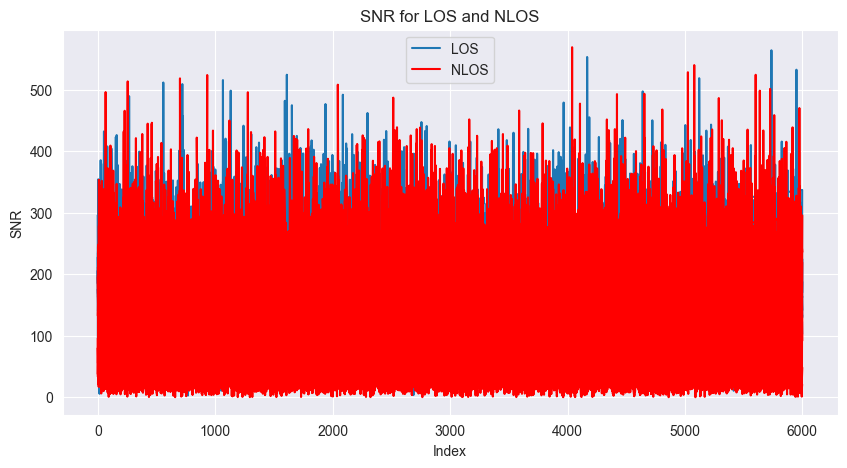

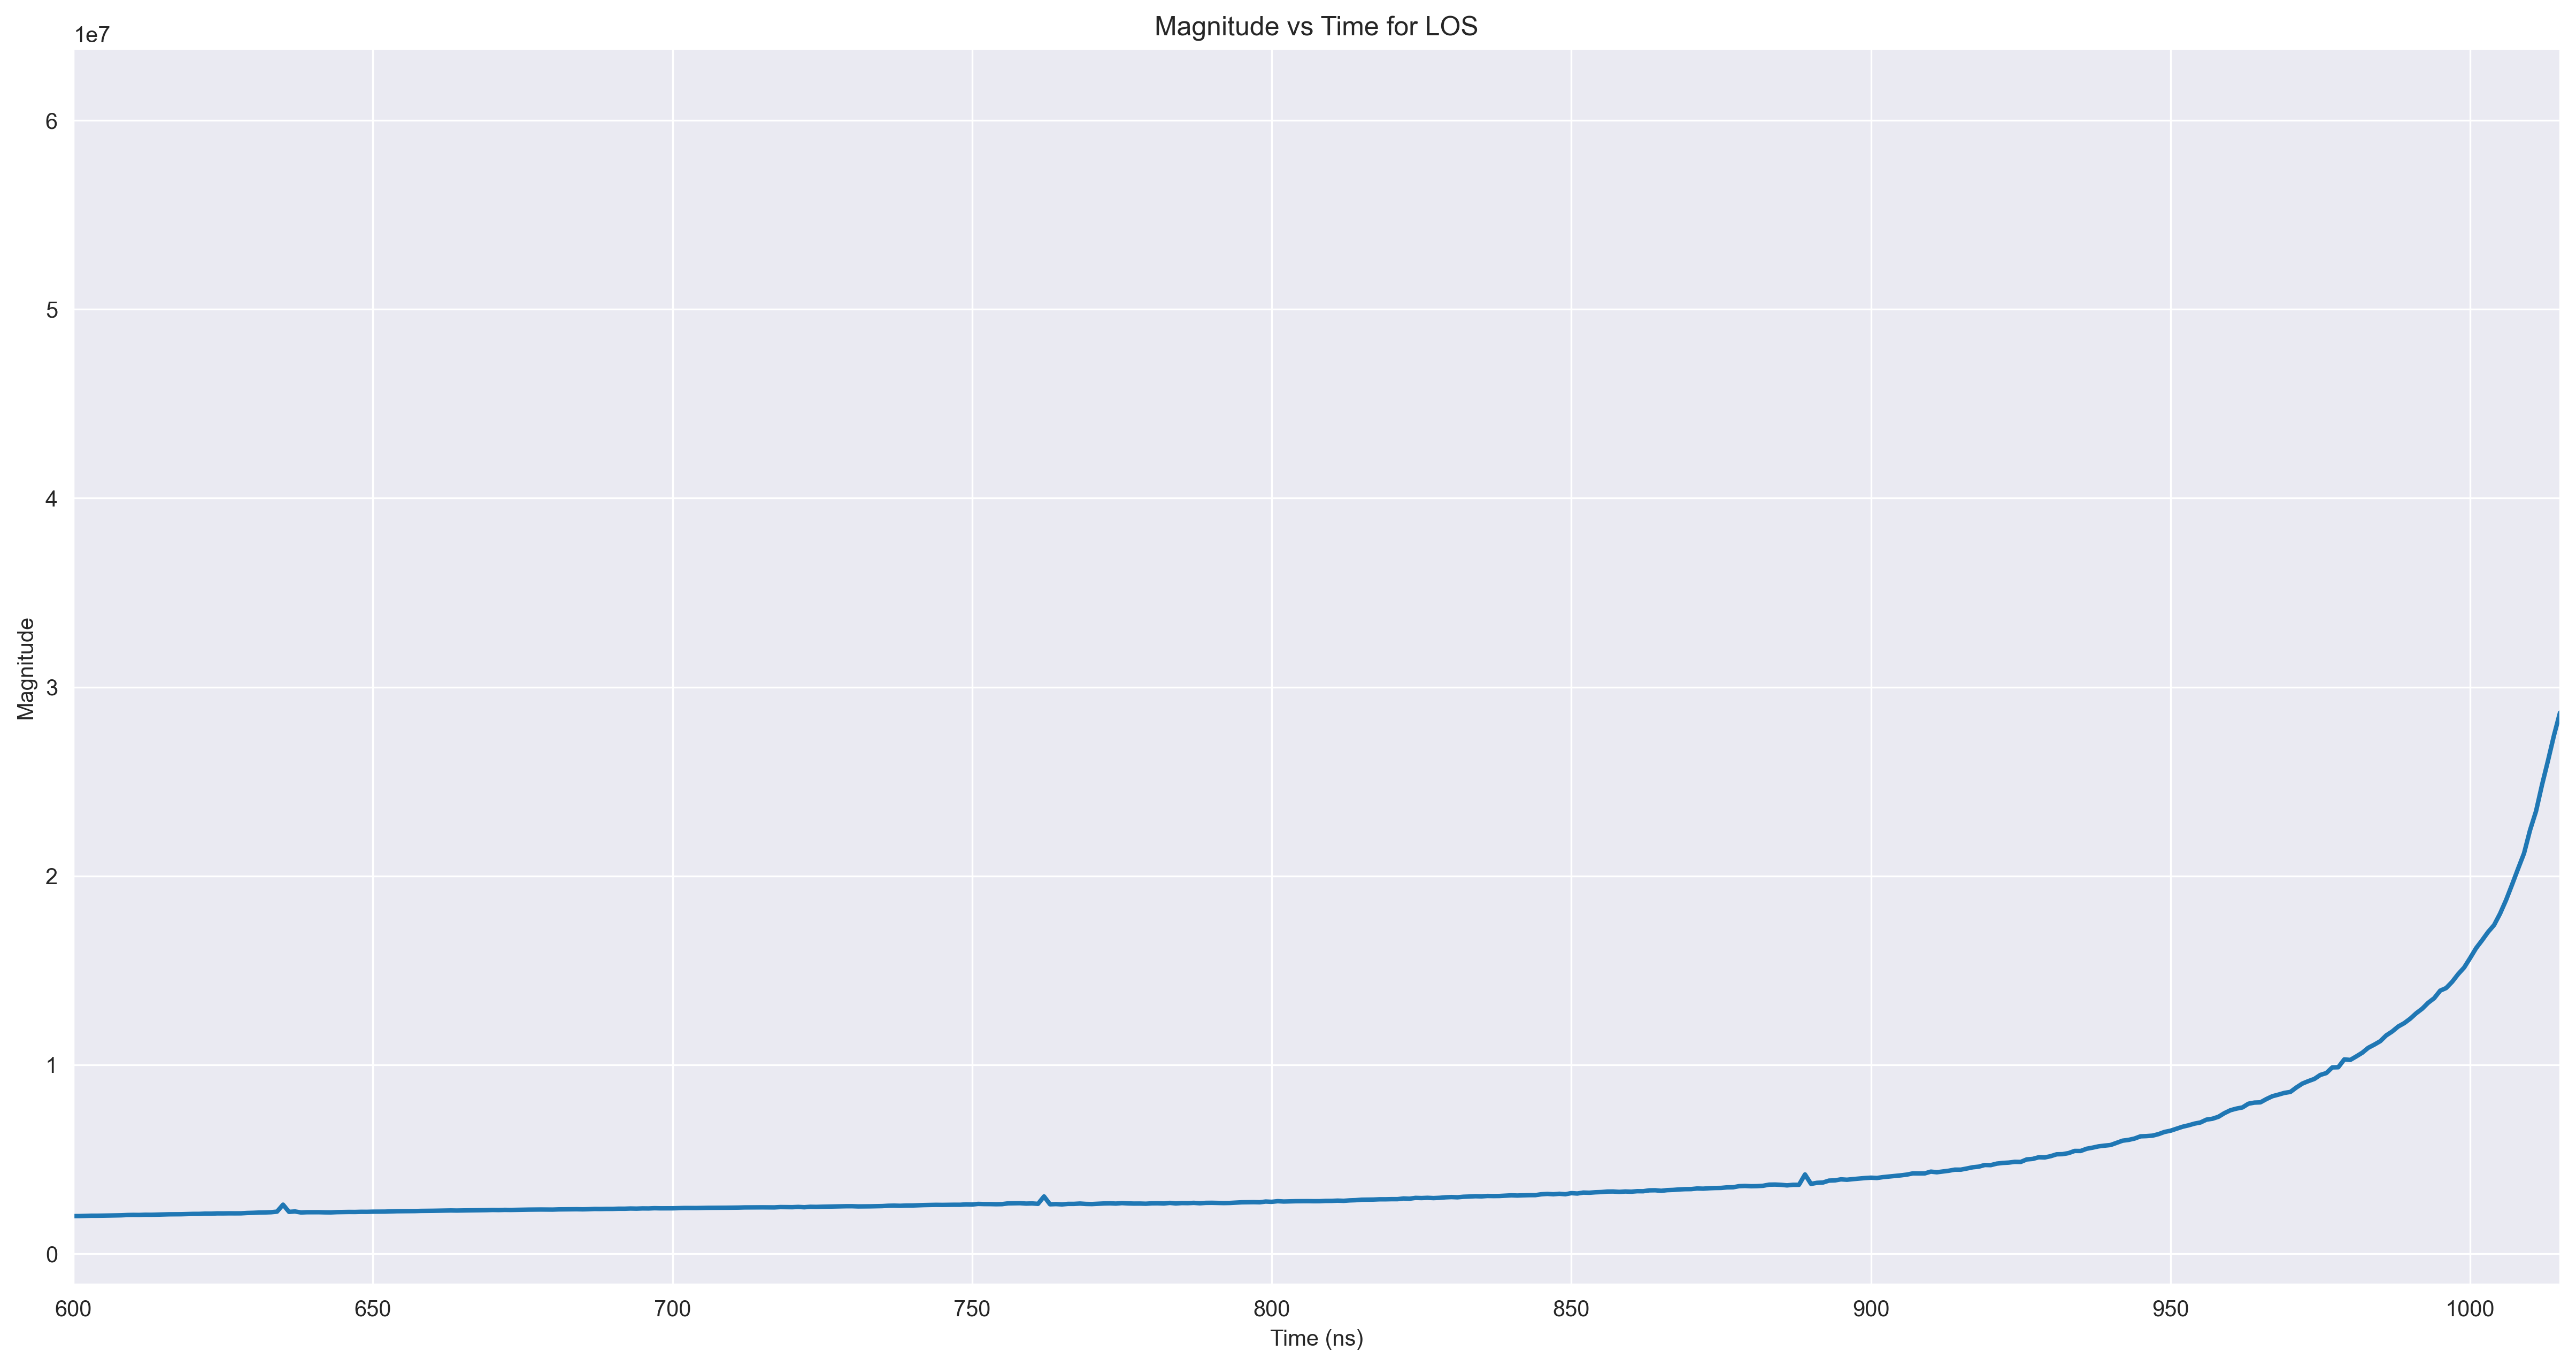

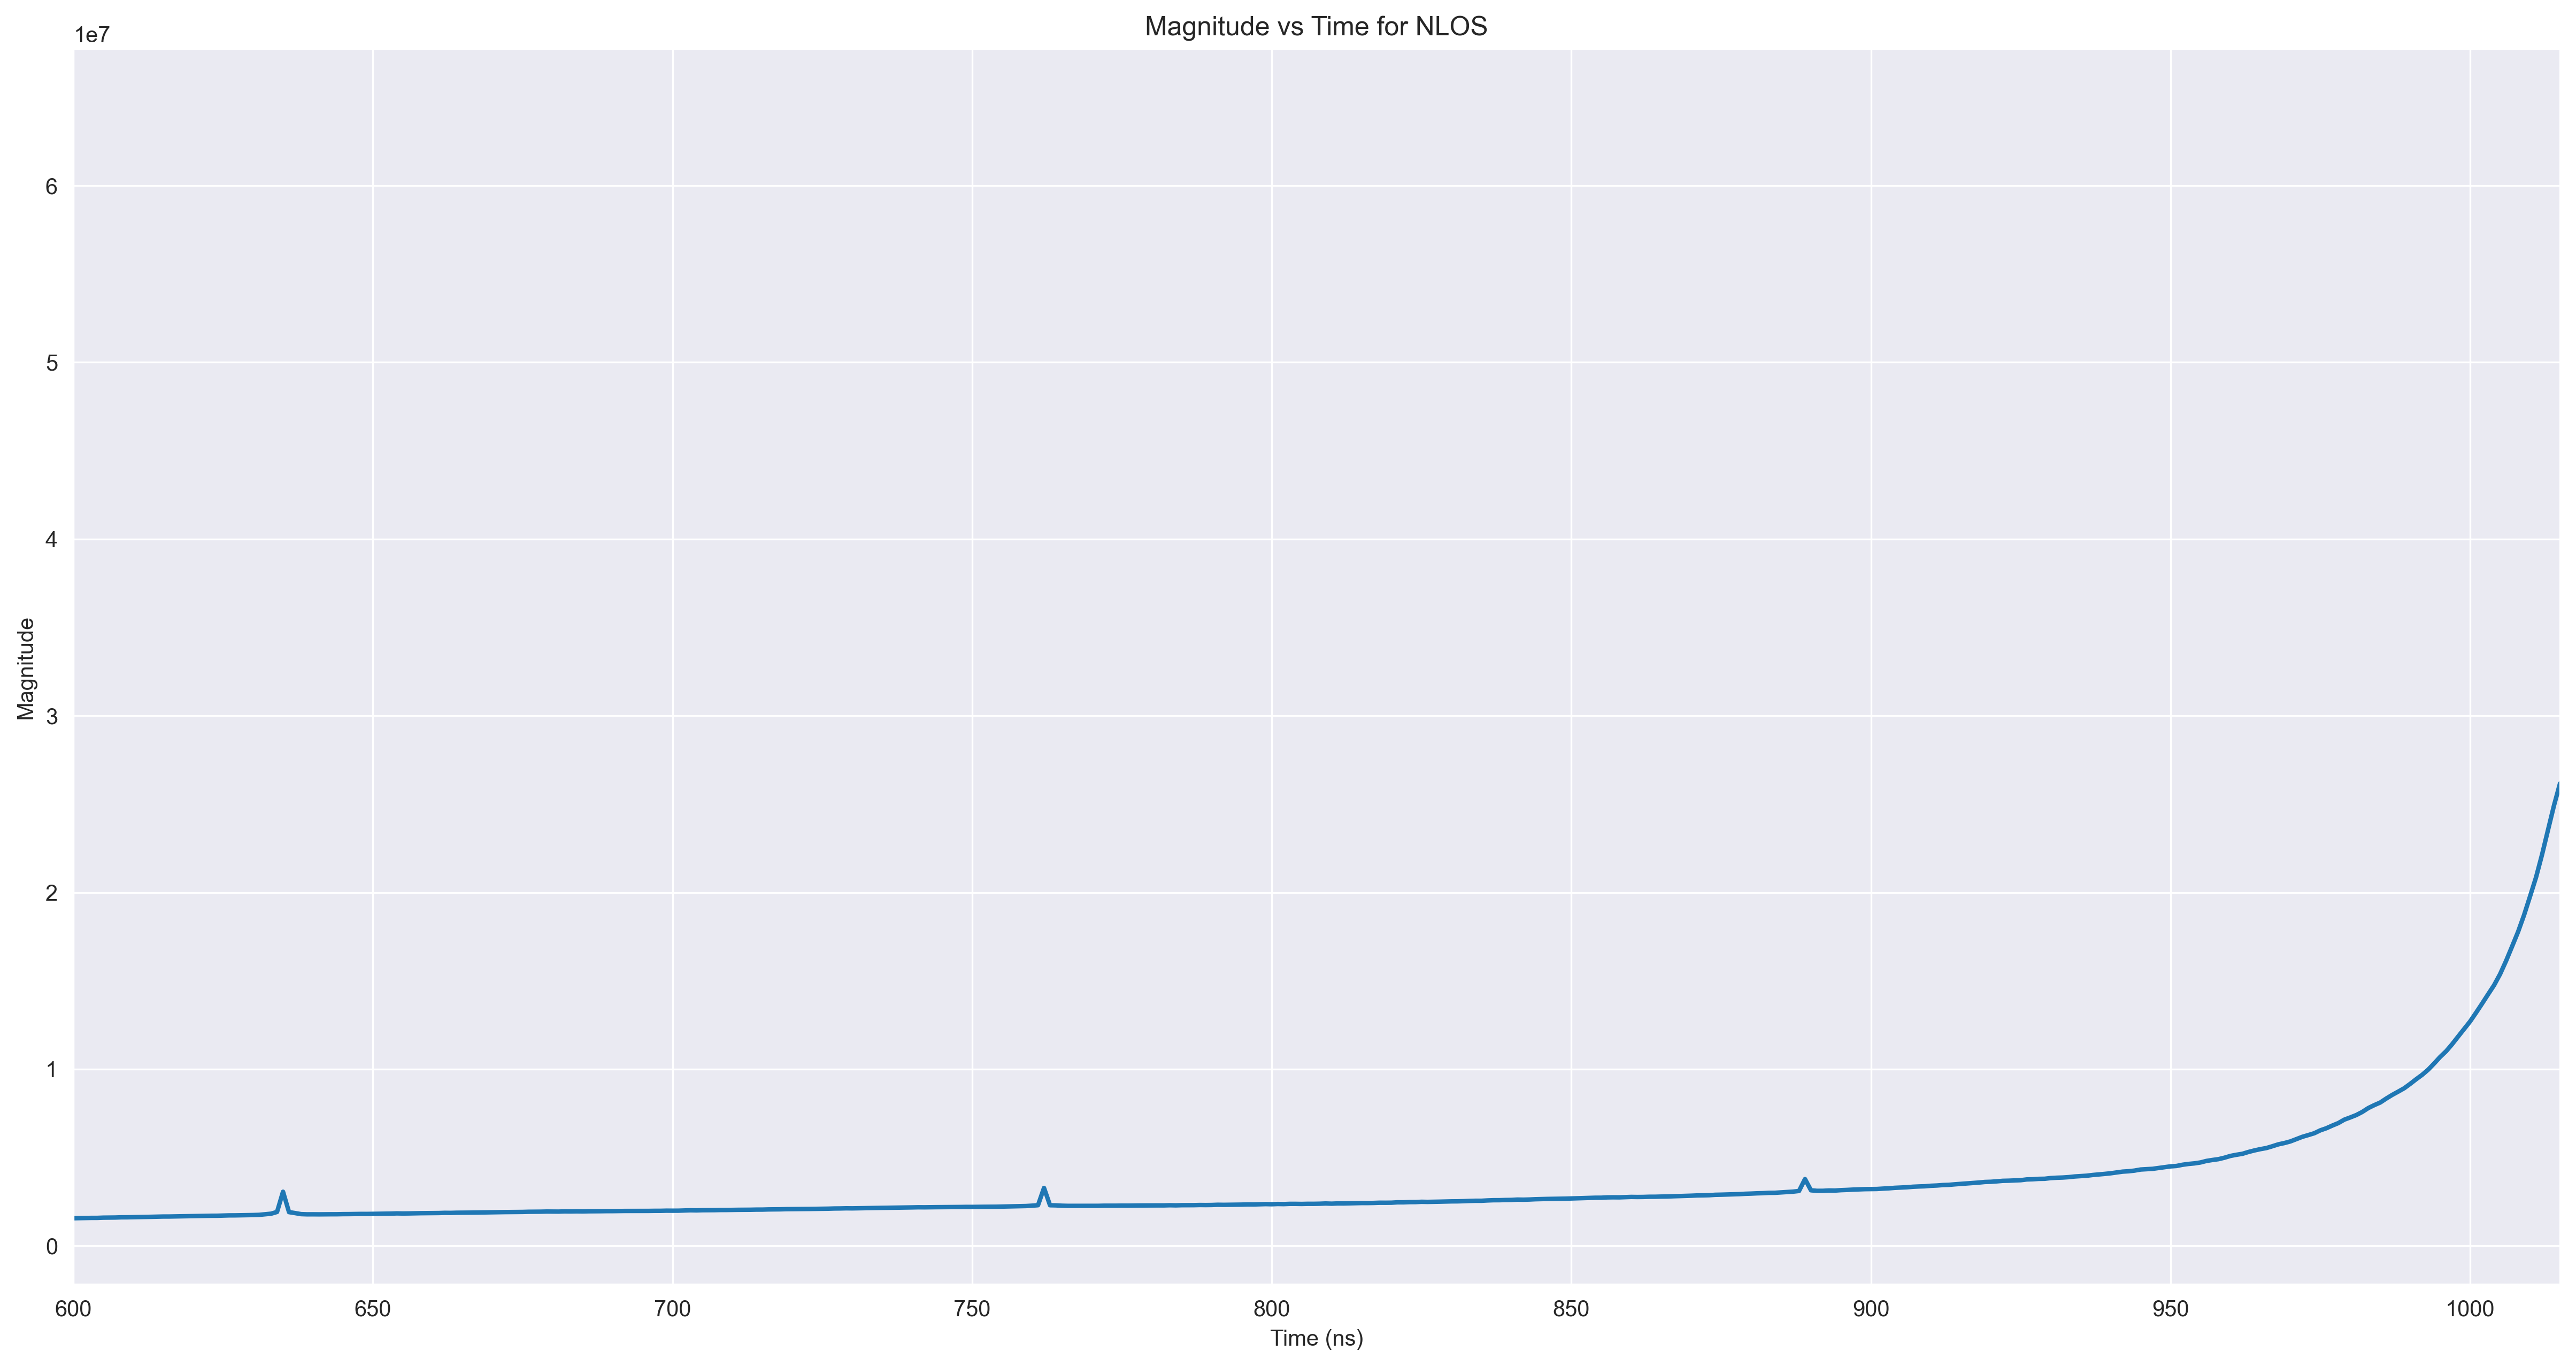

Data loaded successfully.
First few rows of the data:
   NLOS  RANGE  FP_IDX  MAX_NOISE  FRAME_LEN  PREAM_LEN      CIR0  \
0     0   3.90   745.0      967.0          2          0  401549.0   
1     0   0.66   749.0     1133.0          0          0  451165.0   
2     1   7.86   746.0      894.0          0          0  511541.0   
3     1   3.48   750.0     1127.0          2          0  419663.0   
4     0   1.19   746.0     1744.0          0          0  369171.0   

            CIR1           CIR2           CIR3  ...        CIR1010  \
0  176143.139130  172218.295753  170881.074380  ...  164661.802783   
1  248007.108944  247273.488409  242363.138758  ...  222944.309688   
2  282638.075317  277560.207867  262890.558709  ...  198740.768169   
3  143584.438466  152201.642761  144111.339108  ...  138569.940418   
4  149284.240427  145627.201594  140699.927983  ...  126080.397723   

         CIR1011        CIR1012        CIR1013        CIR1014        CIR1015  \
0  170808.640426  169869.36143

In [52]:
import pickle

# File='data_original.pkl'
File = 'data.pkl'

# Check if the file exists
if os.path.exists(File):
    # If the file exists, load it
    print("Loading data from pickle file...")
    with open(File, 'rb') as f:
        data = pickle.load(f)
        # plot_features(data, data['NLOS'], "First_Path_Power_Level", "RX_Level")
        # plot_features(data, data['NLOS'], "SNR", "RX_Level")
        # plot_features(data, data['NLOS'], "SNR", "First_Path_Power_Level")
        snr_graph(data)
        cir_graphs(data)
    print("Data loaded successfully.")
else:
    # If the file doesn't exist, load and clean the data
    print("Pickle file not found. Loading and cleaning data...")
    data = load_data(DATASET_DIR)
    cir_graphs(data)
    data = clean_data(data)
    plot_features(data, data['NLOS'], "First_Path_Power_Level", "RX_Level")
    snr_graph(data)
    cir_graphs(data)
    print(calculate_total_distance(data))
    print("Data loaded and cleaned successfully.")
    print("Saving cleaned data to pickle file...")
    with open(File, 'wb') as f:
        pickle.dump(data, f)
    print("Cleaned data saved to pickle file successfully.")

print("First few rows of the data:")
print(data.head())

# Print Headers
print("Column headers:")
print(data.columns)

# Data Preprocessing

# Train and Save Model

This code block defines a function `train_and_save_model` to train a classifier on the training data and save the trained model to a file. The function takes the following parameters:

- `classifier`: The classifier to train and save.
- `X_train`: The training data.
- `y_train`: The training labels.
- `file_name`: The name of the file to save the trained model to.

In [53]:
MODEL_DIR = './models'


def train_and_save_model(classifier, X_train, y_train, file_name):
    if not os.path.exists(MODEL_DIR):
        os.makedirs(MODEL_DIR)

    file_path = os.path.join(MODEL_DIR, file_name)

    # Check if the file exists
    if not os.path.exists(file_path):
        print(f"Training the model and saving it to {file_path}")
        # Train the classifier
        classifier.fit(X_train, y_train)

        # Save the trained model as a pickle string.
        saved_model = pickle.dumps(classifier)

        # Save the pickled model to a file
        with open(file_path, 'wb') as file:
            file.write(saved_model)

    # Load the pickled model from the file
    with open(file_path, 'rb') as file:
        loaded_model = pickle.load(file)

    return loaded_model

# Split the Data

This code block splits the data into training and testing sets using the `train_test_split` function from the `sklearn.model_selection` module. The training set contains 80% of the data, and the testing set contains 20% of the data.

The target column 'NLOS' is separated from the rest of the dataset, and the input data is scaled using the `StandardScaler` from the `sklearn.preprocessing` module. The `StandardScaler` standardizes features by removing the mean and scaling to unit variance.

The random seed is set to 42 for reproducibility.

In [54]:
# Set random seed for reproducibility
tf.random.set_seed(42)

# Drop the target column 'NLOS' from the data and assign the remaining data to X
X = data.drop('NLOS', axis=1)
# Assign the target column 'NLOS' to y
y = data['NLOS']

# Split the data into training and testing sets with a 80:20 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize a StandardScaler object
scaler = StandardScaler()
# Fit the scaler to the training data and transform it
X_train = scaler.fit_transform(X_train)
# Transform the testing data using the fitted scaler
X_test = scaler.transform(X_test)

# Convolution Neural Network

This code block constructs and trains a Convolutional Neural Network (CNN) for a binary classification task using TensorFlow. CNNs are a type of deep learning model primarily used for image analysis, but they can also be applied to other types of data that have a grid-like topology. Here's a step-by-step breakdown of the code:

1. **Model Creation**: A Sequential model is created using Keras. This model is composed of the following layers:

   - **Conv1D layers**: These are convolutional layers that will convolve the input data with a set of learnable filters, each producing one feature map in the output. The kernel size is set to 3, and the activation function used is ReLU (Rectified Linear Unit).

   - **MaxPooling1D layers**: These layers are used to down-sample the input along its spatial dimensions (height and width). The pool size is set to 2.

   - **Dense layers**: These are fully connected layers. The first Dense layer has 64 units and uses the ReLU activation function. The second Dense layer has a number of units equal to the number of classes and uses the softmax activation function to output a probability distribution over the classes.

2. **Model Compilation**: The model is compiled with the Adam optimizer, categorical cross-entropy loss function, and accuracy as the evaluation metric.

3. **Model Training**: The model is trained on the training data for 10 epochs with a batch size of 32. The validation data is set to the testing set.

4. **Model Evaluation**: The model's performance is evaluated on the testing set and the accuracy is printed.

The mathematical concept behind the Convolutional layer (Conv1D) is the convolution operation, which is a mathematical operation on two functions that produces a third function. In the context of a CNN, the two functions are the input data and the kernel or filter. The convolution operation involves sliding the kernel across the input data and computing the dot product at each position.

The mathematical formula for the convolution operation is:  $$ (f * g)(t) = \int_{-\infty}^{\infty} f(\tau)g(t - \tau) d\tau $$  Where:  
- $f$ and $g$ are the input data and kernel respectively
- $t$ is the position of the kernel
- $\tau$ is a dummy integration variable

In the context of a CNN, the integral is replaced by a sum over the discrete spatial dimensions (height and width) of the input data and kernel.

In [55]:
# Initialize a Sequential model
model = Sequential()

# Add a Conv1D layer
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1),
                 kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Add another Conv1D layer
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Add a Flatten layer
model.add(Flatten())

# Add a Dense layer
model.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Add the output Dense layer
model.add(Dense(1, activation='sigmoid'))

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Compile the model
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test),
                    callbacks=[early_stopping])

# Evaluate the model
scores = model.evaluate(X_test, y_test, verbose=0)

# Make predictions
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype("int32")

# Generate a classification report
report = classification_report(y_test, y_pred_classes)

Epoch 1/30
1050/1050 [==============================] - 27s 25ms/step - loss: 0.5833 - accuracy: 0.7756 - val_loss: 0.4791 - val_accuracy: 0.8193
Epoch 2/30
1050/1050 [==============================] - 26s 25ms/step - loss: 0.4959 - accuracy: 0.8182 - val_loss: 0.4292 - val_accuracy: 0.8457
Epoch 3/30
1050/1050 [==============================] - 27s 25ms/step - loss: 0.4589 - accuracy: 0.8369 - val_loss: 0.4072 - val_accuracy: 0.8573
Epoch 4/30
1050/1050 [==============================] - 27s 25ms/step - loss: 0.4420 - accuracy: 0.8444 - val_loss: 0.4041 - val_accuracy: 0.8594
Epoch 5/30
1050/1050 [==============================] - 26s 25ms/step - loss: 0.4318 - accuracy: 0.8508 - val_loss: 0.3954 - val_accuracy: 0.8630
Epoch 6/30
1050/1050 [==============================] - 27s 25ms/step - loss: 0.4216 - accuracy: 0.8546 - val_loss: 0.3894 - val_accuracy: 0.8643
Epoch 7/30
1050/1050 [==============================] - 27s 26ms/step - loss: 0.4120 - accuracy: 0.8565 - val_loss: 0.3842 -

# Plot the training and validation accuracy over epochs

This code block plots the training and validation accuracy over epochs. The training accuracy is plotted in red, and the validation accuracy is plotted in blue. The x-axis represents the number of epochs, and the y-axis represents the accuracy. The plot shows how the accuracy changes over the course of training and validation.

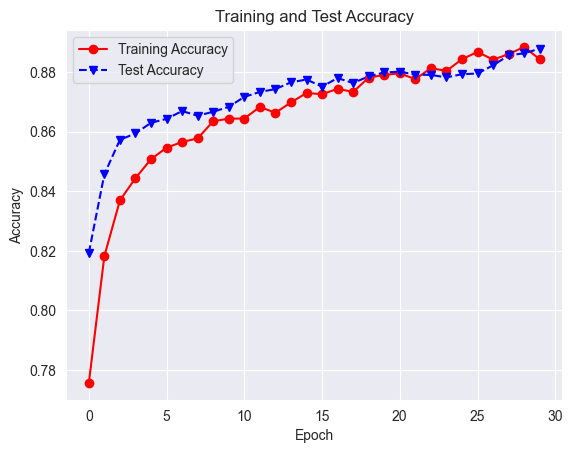

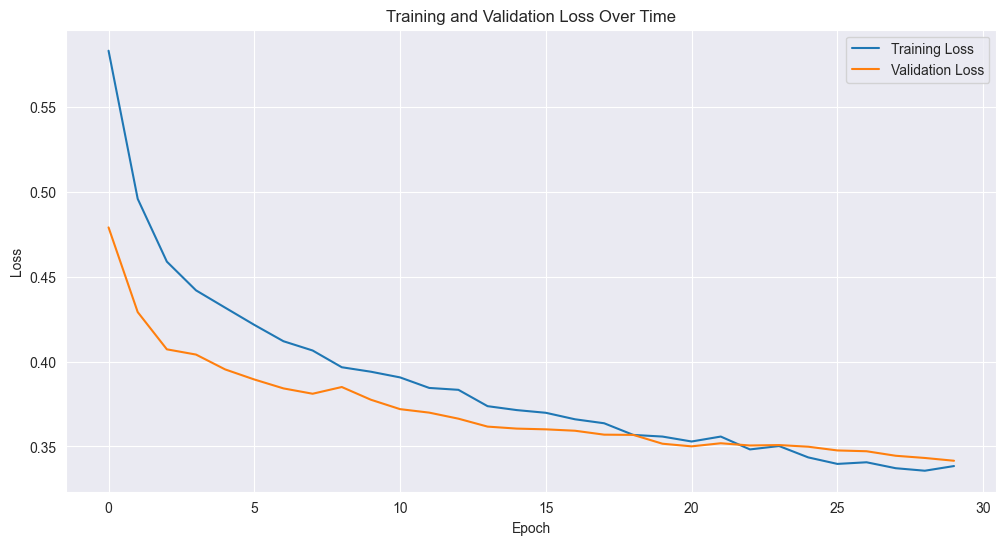

Test loss: 0.34150493144989014
Test accuracy: 0.8878571391105652
Classification Report: 
               precision    recall  f1-score   support

           0       0.86      0.92      0.89      4192
           1       0.92      0.85      0.88      4208

    accuracy                           0.89      8400
   macro avg       0.89      0.89      0.89      8400
weighted avg       0.89      0.89      0.89      8400


In [56]:
# Plot the training and validation accuracy over epochs
plt.plot(history.history['accuracy'], 'ro-', history.history['val_accuracy'], 'bv--')
plt.title('Training and Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Test Accuracy'])
plt.show()

# Plot the training and validation loss over epochs
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Print the testing loss and accuracy
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

# Print the classification report
print('Classification Report: \n', report)


# Visualize Weights and Biases

This code block visualizes the weights and biases of the model. For each Dense layer in the model, the weights and biases are extracted and plotted as histograms. The weights are plotted in the left subplot, and the biases are plotted in the right subplot. The x-axis represents the value of the weights or biases, and the y-axis represents the frequency of occurrence of each value. The histograms show the distribution of the weights and biases in each layer.

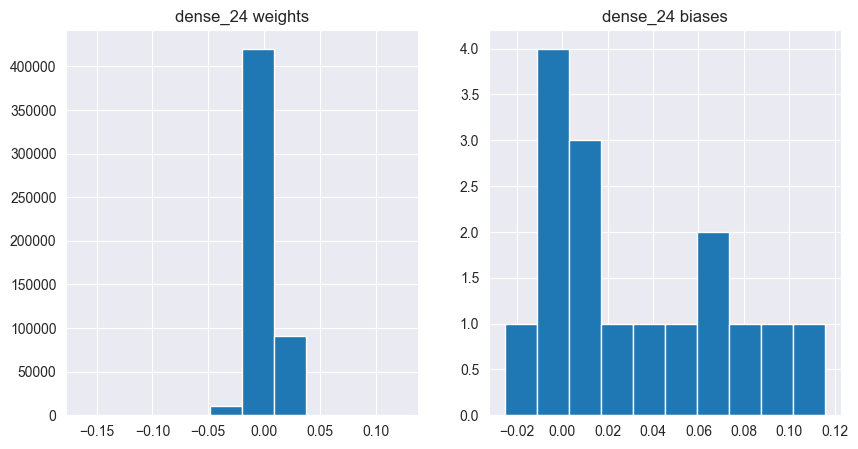

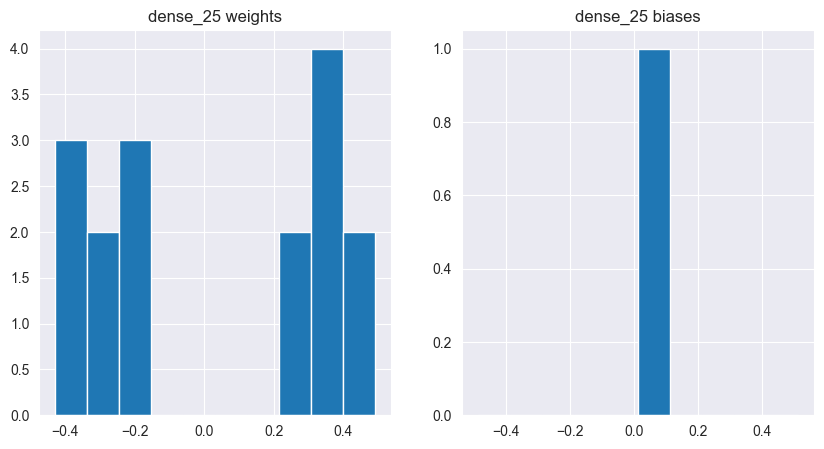

In [57]:
# Visualize Weights and Biases
for layer in model.layers:
    if 'dense' in layer.name:
        weights, biases = layer.get_weights()
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.hist(weights.flatten())
        plt.title(f'{layer.name} weights')
        plt.subplot(1, 2, 2)
        plt.hist(biases.flatten())
        plt.title(f'{layer.name} biases')
        plt.show()



# Confusion Matrix

This code block plots the confusion matrix for the model's predictions on the testing set. The confusion matrix is a table that is often used to describe the performance of a classification model on a set of test data for which the true values are known. The confusion matrix shows the number of true positive, true negative, false positive, and false negative predictions made by the model.

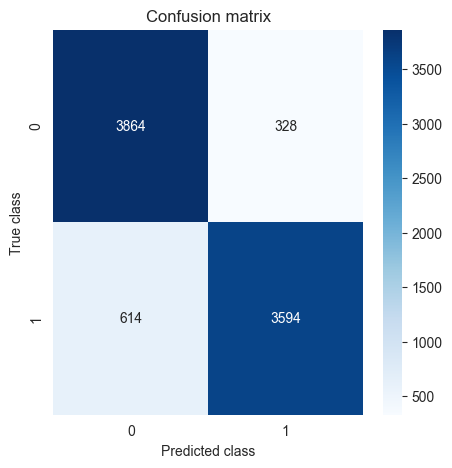

In [58]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion matrix')
plt.xlabel('Predicted class')
plt.ylabel('True class')
plt.show()


# ROC Curve

This code block plots the Receiver Operating Characteristic (ROC) curve for the model's predictions on the testing set. The ROC curve is a graphical plot that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied. The curve is created by plotting the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings. The area under the ROC curve (AUC) is also calculated and printed.

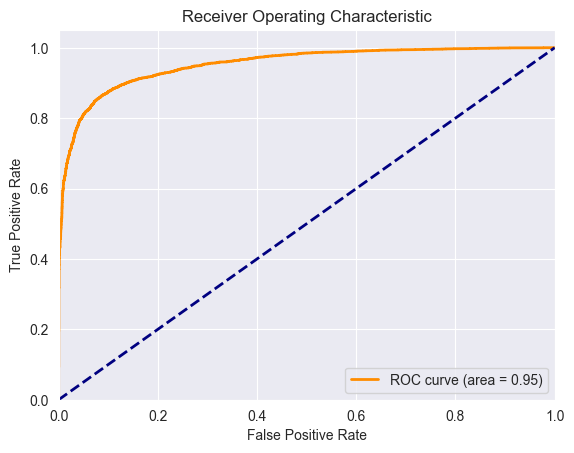

In [59]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Plot the model

This code block plots the model architecture using the `plot_model` function from Keras. The plot shows the structure of the model, including the input and output shapes, the layers, and the connections between layers.

In [60]:
# Plot the model
from tensorflow.keras.utils import plot_model

# Generate the plot
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


# Learning Curve

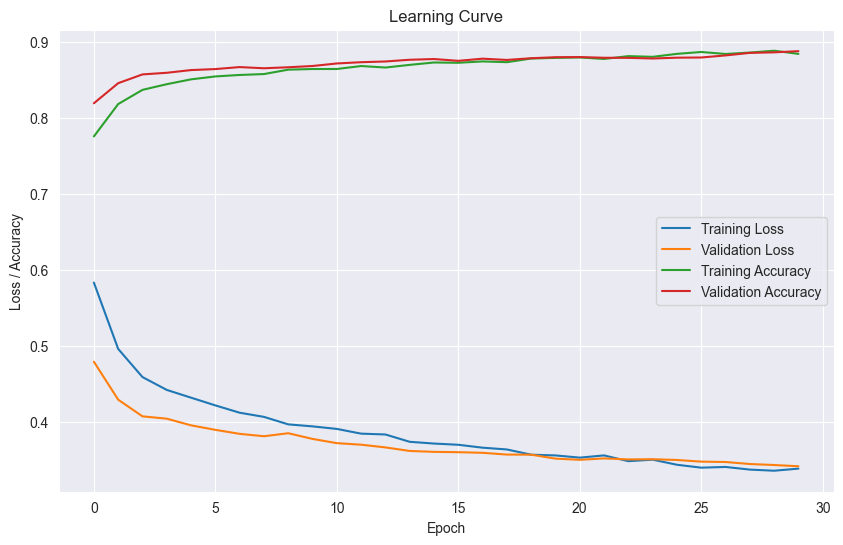

In [61]:
# Learning Curve
plot_learning_curve(history)

# Multi-Layer Perceptron (MLP)

This code block is implementing a Multi-Layer Perceptron (MLP) for a binary classification task using TensorFlow. The MLP is a class of feedforward artificial neural network that consists of at least three layers of nodes: an input layer, a hidden layer, and an output layer. Except for the input nodes, each node is a neuron that uses a nonlinear activation function. MLP utilizes a supervised learning technique called backpropagation for training.

Here's a step-by-step breakdown of what the code does:

1. **Model Creation**: A Sequential model is created using Keras. This model is composed of the following layers:
    - Dense layers: These are fully connected layers. The first Dense layer has 64 units and uses the ReLU activation function. The second and third Dense layers have 32 and 16 units respectively, and also use the ReLU activation function. The final Dense layer has 1 unit and uses the sigmoid activation function for binary classification.
    - BatchNormalization layers: These layers are used to normalize the activations of the previous layer, which speeds up learning and provides some regularization, reducing generalization error.
    - Dropout layers: These layers are used to prevent overfitting. They randomly set a fraction of input units to 0 at each update during training time.

2. **Model Compilation**: The model is compiled with the Adam optimizer, binary cross-entropy loss function, and accuracy as the evaluation metric.

3. **Model Training**: The model is trained on the training data for 20 epochs with a batch size of 32. The validation data is set to the testing set. Early stopping is used to stop training when the validation loss has not improved for 10 epochs.

4. **Model Evaluation**: The model's performance is evaluated on the testing data and the loss and accuracy are printed. The model also makes predictions on the testing data, converts the predicted probabilities to binary outputs, and generates a classification report.

5. **Visualization**: The training and validation accuracy and loss over epochs are plotted.

The mathematical concept behind the Dense layer is the dot product operation, which is a mathematical operation that takes two equal-length sequences of numbers and returns a single number. In the context of a MLP, the two sequences are the input data and the weights of the neurons. The dot product operation involves multiplying each pair of input and weight and summing the result.

The mathematical formula for the dot product operation is: $$ a \cdot b = \sum_{i=1}^{n} a_i b_i $$ Where:
- $a$ and $b$ are the input data and weights respectively
- $n$ is the number of dimensions (length of the sequences)
- $a_i$ and $b_i$ are the $i$-th elements of the input data and weights respectively.

Epoch 1/20
1050/1050 [==============================] - 3s 1ms/step - loss: 0.9170 - accuracy: 0.6429 - val_loss: 0.6545 - val_accuracy: 0.7518
Epoch 2/20
1050/1050 [==============================] - 2s 2ms/step - loss: 0.7946 - accuracy: 0.6978 - val_loss: 0.6269 - val_accuracy: 0.7786
Epoch 3/20
1050/1050 [==============================] - 2s 2ms/step - loss: 0.7336 - accuracy: 0.7254 - val_loss: 0.6138 - val_accuracy: 0.7845
Epoch 4/20
1050/1050 [==============================] - 2s 2ms/step - loss: 0.6988 - accuracy: 0.7419 - val_loss: 0.5919 - val_accuracy: 0.7999
Epoch 5/20
1050/1050 [==============================] - 2s 1ms/step - loss: 0.6646 - accuracy: 0.7605 - val_loss: 0.5755 - val_accuracy: 0.8098
Epoch 6/20
1050/1050 [==============================] - 1s 1ms/step - loss: 0.6390 - accuracy: 0.7719 - val_loss: 0.5508 - val_accuracy: 0.8233
Epoch 7/20
1050/1050 [==============================] - 1s 1ms/step - loss: 0.6062 - accuracy: 0.7902 - val_loss: 0.5226 - val_accuracy:

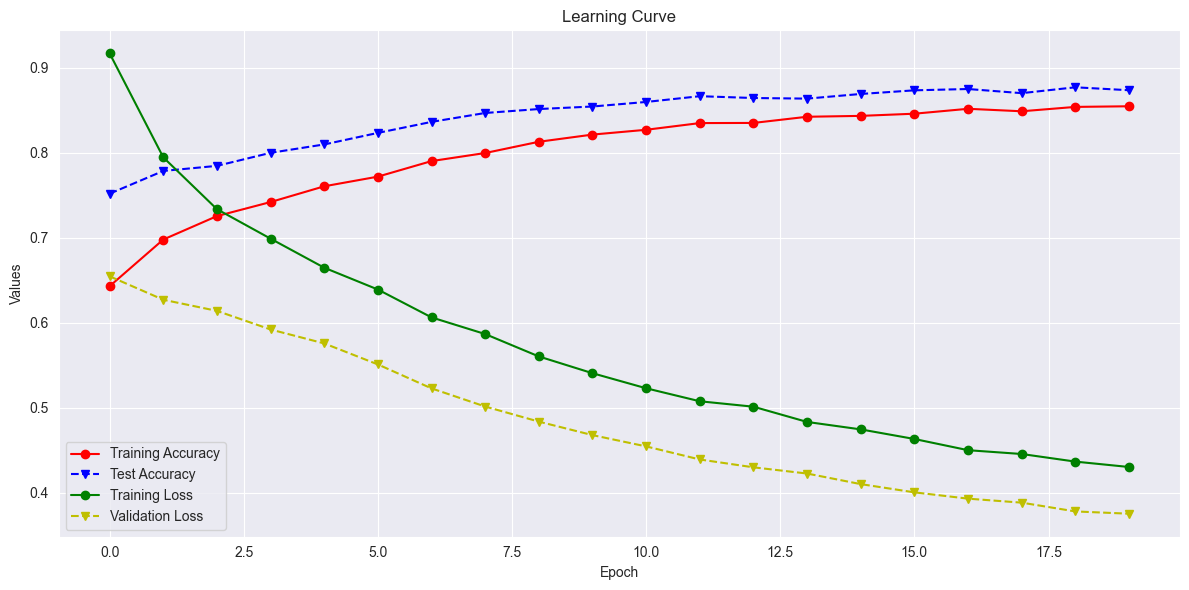

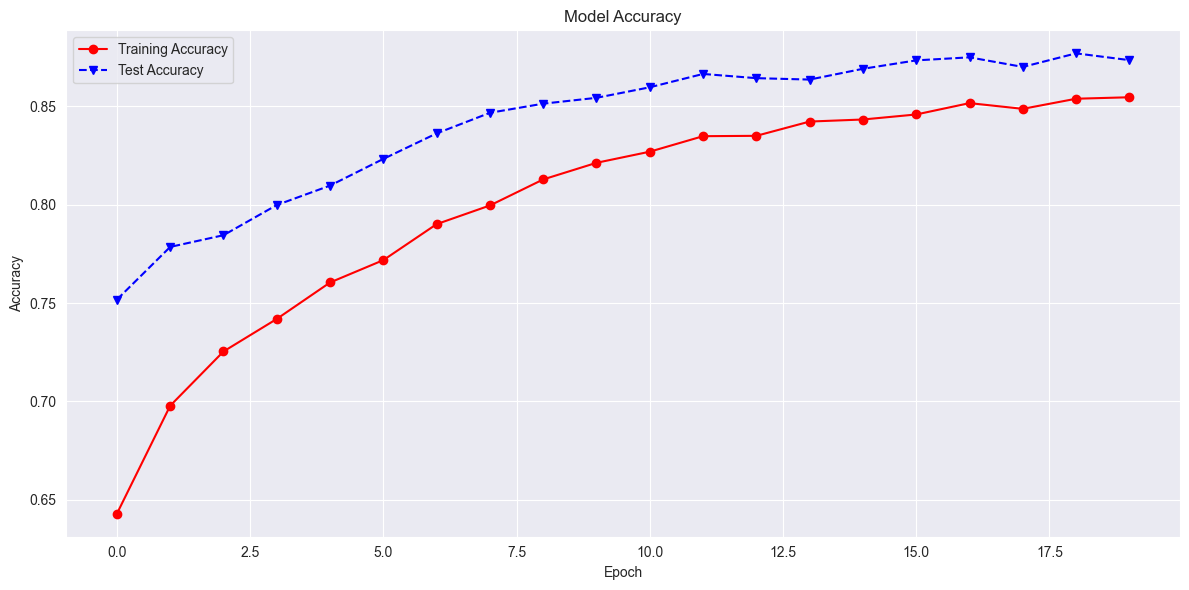

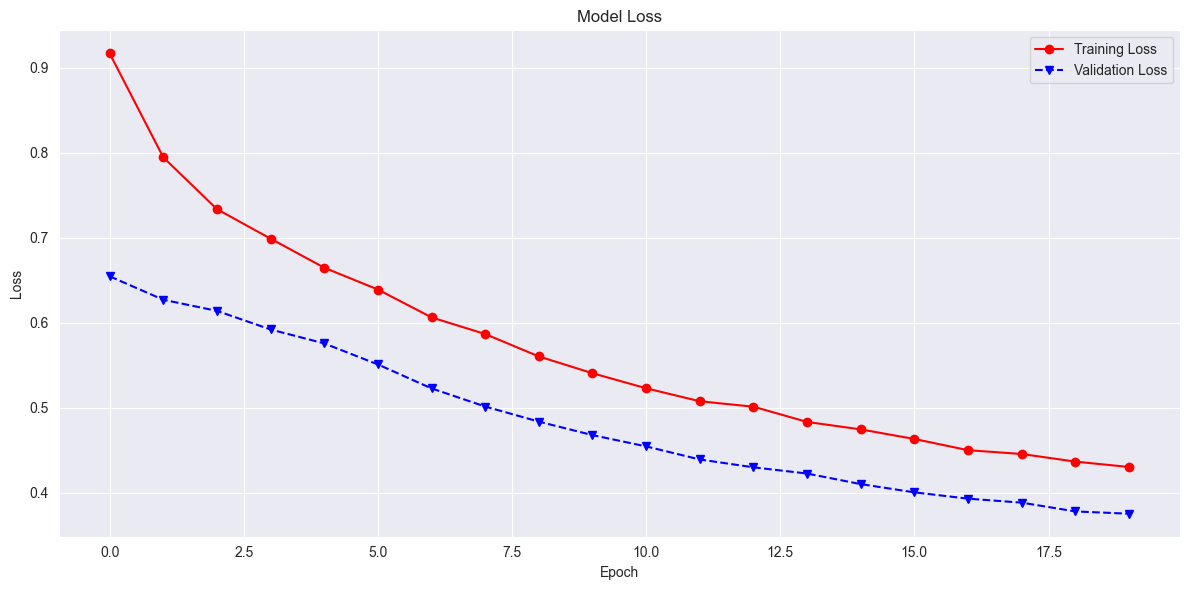

<Figure size 640x480 with 0 Axes>

Test loss: 0.37507084012031555
Test accuracy: 0.8735714554786682
Classification Report: 
               precision    recall  f1-score   support

           0       0.84      0.93      0.88      4192
           1       0.92      0.82      0.87      4208

    accuracy                           0.87      8400
   macro avg       0.88      0.87      0.87      8400
weighted avg       0.88      0.87      0.87      8400


In [77]:
# Initialize a Sequential model
model = Sequential()
# Add a Dense layer with 64 units, ReLU activation function and L2 regularization
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=regularizers.l2(0.001)))
# Add a BatchNormalization layer to normalize the activations of the previous layer
model.add(BatchNormalization())
# Add a Dropout layer to prevent overfitting
model.add(Dropout(0.5))
# Add another Dense layer with 32 units, ReLU activation function and L2 regularization
model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
# Add another BatchNormalization layer
model.add(BatchNormalization())
# Add another Dropout layer
model.add(Dropout(0.5))
# Add another Dense layer with 16 units, ReLU activation function and L2 regularization
model.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
# Add another BatchNormalization layer
model.add(BatchNormalization())
# Add another Dropout layer
model.add(Dropout(0.5))
# Add the output Dense layer with 1 unit and sigmoid activation function
model.add(Dense(1, activation='sigmoid'))

# Define early stopping to stop training when the validation loss has not improved for 10 epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Compile the model with Adam optimizer, binary cross-entropy loss function and accuracy as the evaluation metric
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

# Train the model on the training data for 20 epochs with a batch size of 32 and validate on the testing data
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test),
                    callbacks=[early_stopping])

# Evaluate the model on the testing data and store the loss and accuracy in 'scores'
scores = model.evaluate(X_test, y_test, verbose=0)

# Make predictions on the testing data
y_pred = model.predict(X_test)
# Convert the predicted probabilities to binary outputs
y_pred_classes = (y_pred > 0.5).astype("int32")
# Generate a classification report
report = classification_report(y_test, y_pred_classes)

fig, ax = plt.subplots(figsize=(12, 6))

# Plot training & validation accuracy values
ax.plot(history.history['accuracy'], 'ro-', label='Training Accuracy')
ax.plot(history.history['val_accuracy'], 'bv--', label='Test Accuracy')

# Plot training & validation loss values
ax.plot(history.history['loss'], 'go-', label='Training Loss')
ax.plot(history.history['val_loss'], 'yv--', label='Validation Loss')

ax.set_title('Learning Curve')
ax.set_ylabel('Values')
ax.set_xlabel('Epoch')
ax.legend()

# Show the figure
plt.tight_layout()
plt.show()

# Create a figure for the accuracy plot
fig1, ax1 = plt.subplots(figsize=(12, 6))

# Plot training & validation accuracy values
ax1.plot(history.history['accuracy'], 'ro-', label='Training Accuracy')
ax1.plot(history.history['val_accuracy'], 'bv--', label='Test Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend()

# Show the figure
plt.tight_layout()
plt.show()

# Create a figure for the loss plot
fig2, ax2 = plt.subplots(figsize=(12, 6))

# Plot training & validation loss values
ax2.plot(history.history['loss'], 'ro-', label='Training Loss')
ax2.plot(history.history['val_loss'], 'bv--', label='Validation Loss')
ax2.set_title('Model Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend()

# Show the figure
plt.tight_layout()
plt.show()

# Show the figure
plt.tight_layout()
plt.show()

# Print the testing loss and accuracy
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])
# Print the classification report
print('Classification Report: \n', report)

# Multi-Layer Perceptron (MLP) visualization
This code block is used to visualize the performance of a trained Multi-Layer Perceptron (MLP) model. It generates three types of visualizations:

1. Weights and Biases Visualization: This visualization is used to understand the distribution of weights and biases in the model's layers. For each layer in the model, if the layer is a dense layer, it retrieves the weights and biases, and plots histograms of their values. The x-axis of the histogram represents the value of the weights/biases and the y-axis represents the frequency of these values.

2. Confusion Matrix: A confusion matrix is a table that is often used to describe the performance of a classification model on a set of test data for which the true values are known. It gives a more detailed breakdown of correct and incorrect classifications for each class.

3. ROC Curve: The Receiver Operating Characteristic (ROC) curve is a plot that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied. It is created by plotting the true positive rate (TPR) against the false positive rate (FPR).

## Weights and Biases Evaluation

The weights and biases of the MLP model layers were visualized to understand their distributions. The weights in all layers (dense, dense_1, dense_2, and dense_3) are not close to zero, indicating they are likely being updated during training and contributing to the model's learning. The weight distributions show a spread around zero, suggesting the model is capturing complex relationships in the data.

The biases in dense and dense_2 introduce a slight positive bias to the activations in subsequent layers, potentially affecting the model's predictions. The biases in dense_1 and dense_3 are centered around zero, with a slight spread towards positive values, introducing a small positive shift in the activations of the next layer.

The impact of these biases would depend on the network architecture and data. Overall, the model's weights and biases suggest that it is learning effectively from the training data.

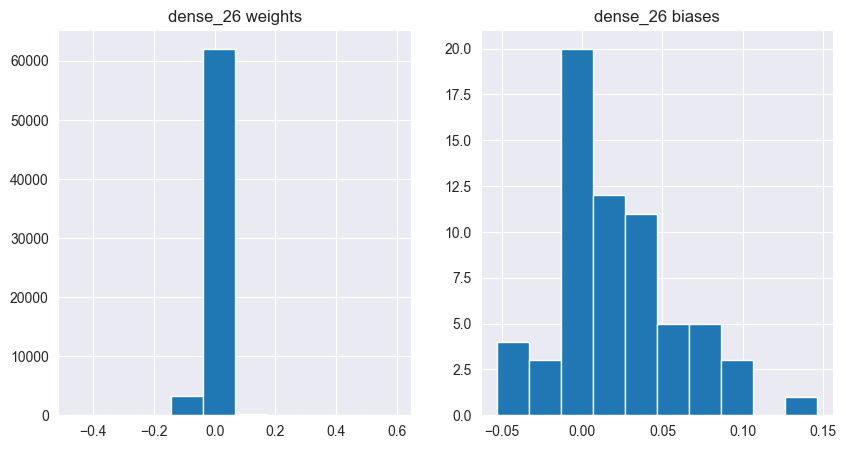

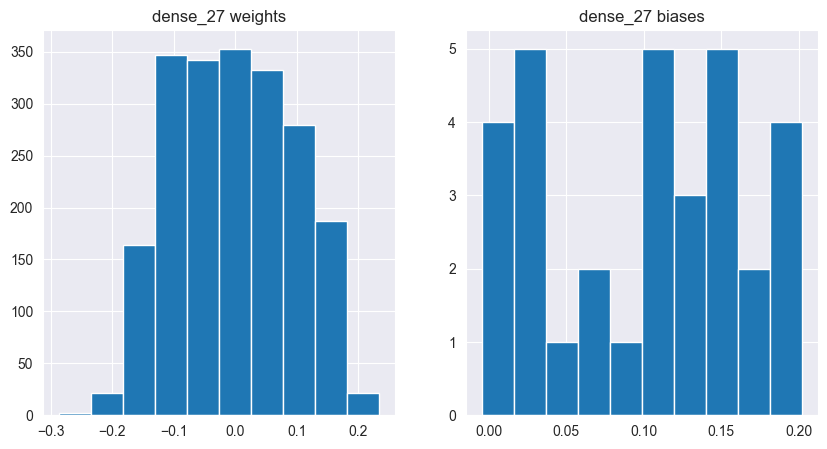

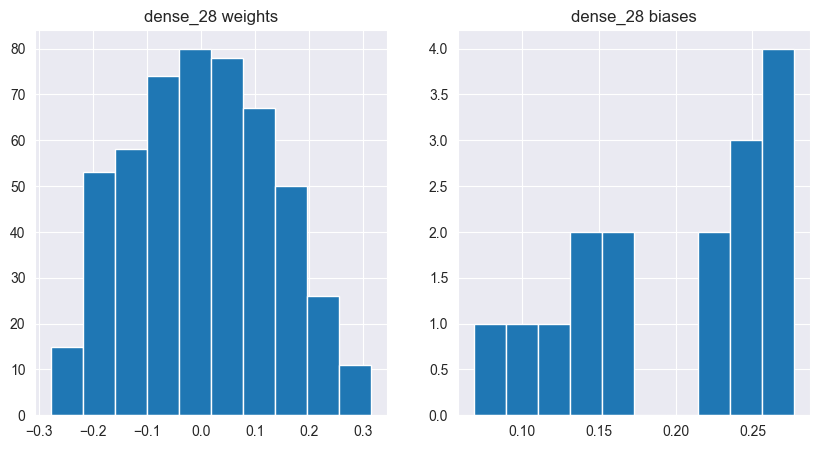

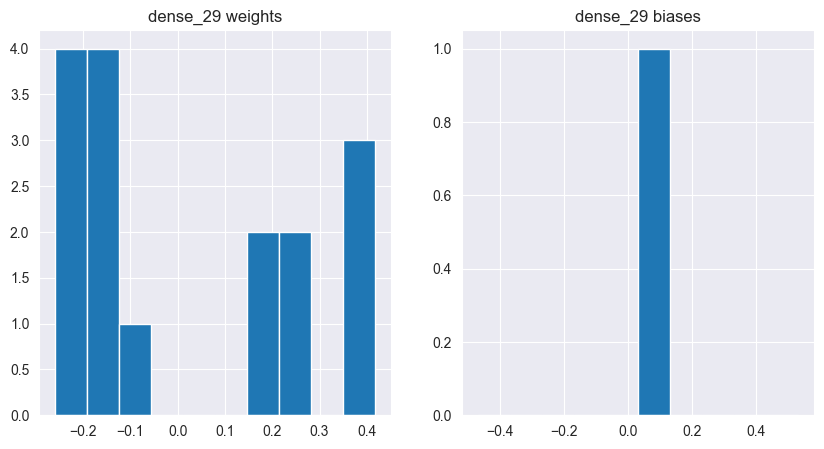

In [63]:
# 1. Visualize Weights and Biases
for layer in model.layers:
    if 'dense' in layer.name:
        weights, biases = layer.get_weights()
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.hist(weights.flatten())
        plt.title(f'{layer.name} weights')
        plt.subplot(1, 2, 2)
        plt.hist(biases.flatten())
        plt.title(f'{layer.name} biases')
        plt.show()

## Confusion Matrix Evaluation

The confusion matrix is a table that is often used to describe the performance of a classification model on a set of test data for which the true values are known. It gives a more detailed breakdown of correct and incorrect classifications for each class.

The confusion matrix shows that the model has a good performance in distinguishing between positive and negative instances. The majority of the instances are correctly classified, with a small number of false positives and false negatives.

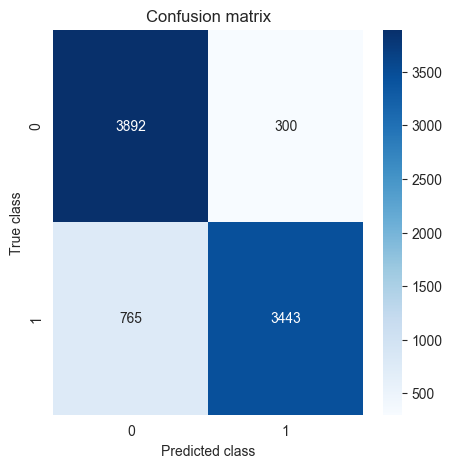

In [64]:
# 2. Confusion Matrix
# Convert the predicted probabilities to binary outputs
y_pred_classes = (y_pred > 0.5).astype("int32")
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
# Plot the confusion matrix
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion matrix')
plt.xlabel('Predicted class')
plt.ylabel('True class')
plt.show()



## ROC Curve Evaluation

The Receiver Operating Characteristic (ROC) curve is a graphical representation that illustrates the performance of a binary classification model at all classification thresholds. It is commonly used in machine learning to evaluate the performance of a classifier system for two-class problems.

The ROC curve has two axes:
- The X-axis represents the False Positive Rate (FPR), which is the proportion of negative instances that are incorrectly classified as positive.
- The Y-axis represents the True Positive Rate (TPR), which is the proportion of positive instances that are correctly classified as positive.

A perfect classifier would classify all positive instances correctly (TPR = 1) and all negative instances correctly (FPR = 0). This would be represented by a curve that goes straight up the left side of the ROC graph and then along the top to the right corner.

The Area Under the Curve (AUC) is a numerical measure of the ROC curve’s performance. A larger AUC indicates a better performance. In our case, the AUC is 0.91, which is considered to be very good.

In summary, the ROC curve shows that our binary classification model has a good performance in distinguishing between positive and negative instances.

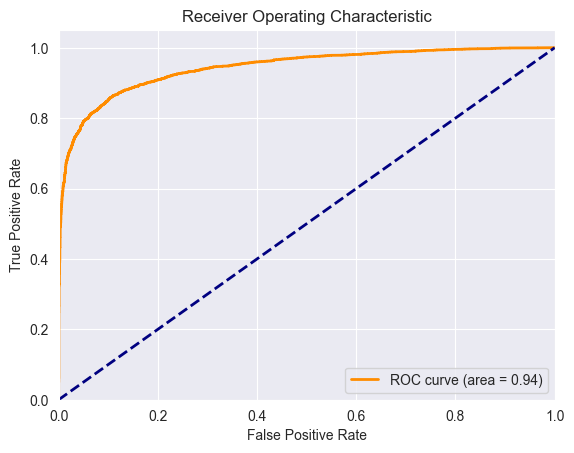

In [65]:
# 3. ROC Curve
# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
# Plot the ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## Learning curve

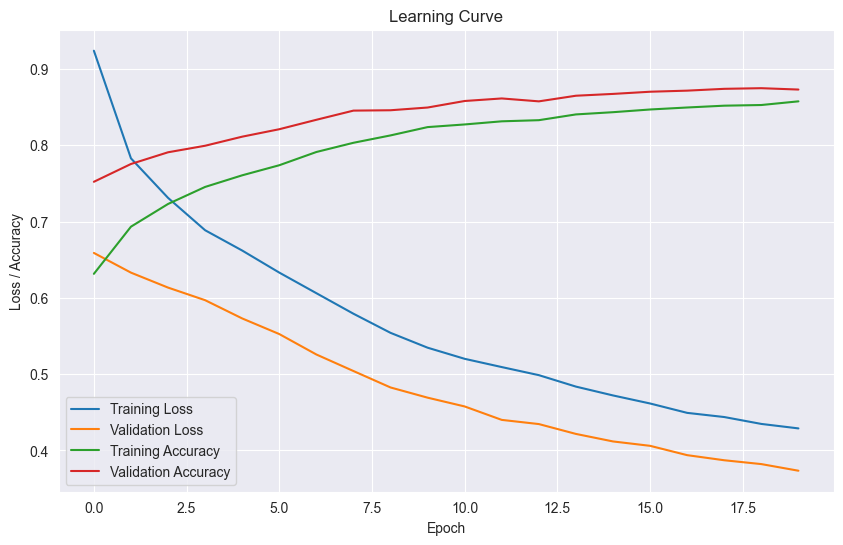

In [66]:



plot_learning_curve(history)
